In [128]:
import numpy as np
import os
import util as u
import MRI_layers_MK1 as mri
import matplotlib.pyplot as plt
import pickle


#import contour #class 

import argparse
#we'll use the above for commandline arguments (scanfiles, maskfile)

#import contour class
from contour import *

<ipython-input-129-53eabb319610>:10: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[4], [0], colors='red')


81

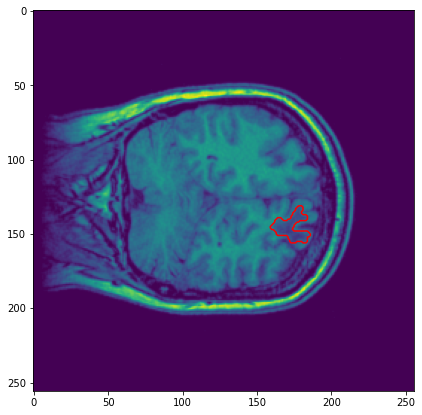

In [129]:
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

s, m = mri.load_data(fpaths[1])

scans, masks = mri.preprocess(s, m, normalize=True, contrast_factor = 2, blur_rad=0.6)

plt.figure(figsize=(7,7))
plt.imshow(scans[4])
plt.contour(masks[4], [0], colors='red')
len(scans)

<ipython-input-130-7f1ca6f57796>:15: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[0], [0], colors='red')


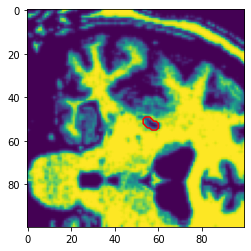

In [130]:
#load data using functions in mri layers module (rename that to mri)
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

s, m = mri.load_data(fpaths[8])

#contrasting works better when you first isolate the part of the image you want 
#add this in the preprocessing pipeline 
_scans = [scan[50:150, 80:180] for scan in s]
_masks = [mask[50:150, 80:180] for mask in m]

scans, masks = mri.preprocess(_scans, _masks, normalize=True, contrast_factor = 12, blur_rad=0.6)

plt.imshow(scans[0])
plt.contour(masks[0], [0], colors='red')

#index 0: 85:165, 130:210
#index 1: 120:190, 130:210
#index 2: 115:185, 100:180
#index 3: 100:190, 90:190
#index 8: 50:150, 80:180
#index 9: 140:210, 140:210

In [110]:
len(masks)

81

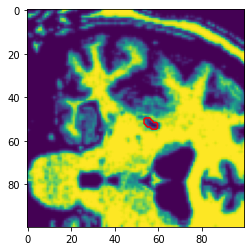

In [131]:
ref = masks[0]

#initial convergence using segmentation
def f0(surface, image):
    F1 = u.mean_curvature(surface)
    F2 = (image-1.0)**2 - (image - 0)**2
    return 0.001*F1 + 0.11*F2

#random circle shape 
p0 = u.parabloid(ref.shape, xrad=0.5, yrad=0.5)
c0 = contour(p0, f0)
c0.iterate(ref, numiters=5500, dt = 0.001)

#check to see that it worked
plt.contour(c0.s, [0], colors='red')
#plt.contour(ref, [0], colors='magenta')
plt.imshow(scans[0])

In [132]:
#now setup some things for the sequential component...

#keep track of contours 
contours = []
contours.append(c0)

#intensities (these are not inherent to dataset, function of preprocess contrast)
interior_intensities = []
exterior_intensities = []

#areas 
area = lambda arr: len(contour.positive_indeces(arr, geq=False))
areas = []
areas.append(area(c0.s))

#supervised:
_areas = [area(mask) for mask in masks]


In [133]:
#numscans = len(scans)-1
numscans = 13

import time 

start = time.time()

for i in range(numscans):
    index = len(contours)
    
    #images and contours we need 
    prev_c = contours[index-1]
    prev_scan = scans[index-1]
    scan = scans[index]
    
    #dynamically define a functional to instantiate contour object with 
    #intensity:
    i_in, i_out = prev_c.intensity(prev_scan, steps=3)
    
    #append 
    interior_intensities.append(i_in)
    exterior_intensities.append(i_out)

    #average vals 
    i_in_avg = np.mean(interior_intensities)
    i_out_avg = np.mean(exterior_intensities)
    
    #area: 
    if index < 4:
        #supervised
        a = _areas[index]
    else:
        increments = np.linspace(0,len(areas)-1, len(areas))
        area_estimator = np.poly1d(np.polyfit(increments, areas, 0.5))
        a = area_estimator(index)
     
    #define functional on a per iteration basis 
    def f(surface, image):
        #arclength
        F1 = u.mean_curvature(surface)
        
        #segmentation
        F2 = (image-i_in_avg)**2 - (image - i_out_avg)**2

        #area 
        F3 = 2*(area(surface) - 1.0*a)
    
        return 0.0003*F1 + 0.06*F2 + 0.02*F3
    
    
    #instantiate new contour object 
    simplified = u.surf2simple(prev_c.s)
    c = contour(simplified, f)
    
    #solve
    c.iterate(scan, numiters=4500, dt=0.00075)
    
    #append
    contours.append(c)
    areas.append(area(c.s))
    
    print(index)

stop = time.time()

print(stop-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
106.13145399093628


<ipython-input-119-af463798d3f1>:6: UserWarning: No contour levels were found within the data range.
  c1 = plt.contour(masks[index], [0], colors='magenta', linewidths=2.5)


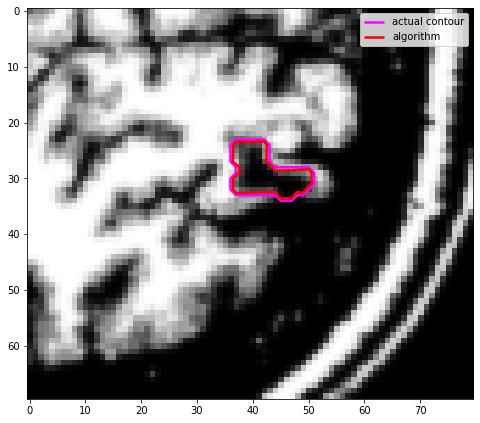

In [119]:
index=0

plt.figure(figsize=(8,8))

plt.imshow(scans[index], cmap='gray')
c1 = plt.contour(masks[index], [0], colors='magenta', linewidths=2.5)
c2 = plt.contour(contours[index].s, [0], colors='red', linewidths=2.5)

h1,_ = c1.legend_elements()
h2,_ = c2.legend_elements()

plt.legend([h1[0], h2[0]], ['actual contour', 'algorithm'])

In [88]:
"""
some issues so far, the area regression can lead to a cascade effect so maybe we consider operation 
where we have the first 3 areas known -- i.e it's supervised 

can we artificially 
"""

"\nsome issues so far, the area regression can lead to a cascade effect so maybe we consider operation \nwhere we have the first 3 areas known -- i.e it's supervised \n\ncan we artificially \n"

In [115]:
#kaitlyn's stuff 
def diceCoef(correct_mask, algo_mask):
    #Calculate how many points intersect
    #Goes in numerator of dice coefficient
    correct_mask_bool = np.asarray(correct_mask).astype(np.bool)
    algo_mask_bool = np.asarray(algo_mask).astype(np.bool)
    
    mask_intersect = np.logical_and(correct_mask_bool, algo_mask_bool)
    total_intersect = mask_intersect.sum()
    
    #Calculate number of points in each mask
    #Goes in denominator of dice coefficent
    points_correct = correct_mask_bool.sum()
    points_algo = algo_mask_bool.sum()
    
    dice_denom_sum = points_correct + points_algo
    
    #Compute dice's coefficient
    diceCoefficient = 2.*total_intersect/dice_denom_sum
    
    #print(diceCoefficient)
    if diceCoefficient == 0: 
        return 0
    else: 
        return diceCoefficient

In [116]:
dicescores = []
for i,c in enumerate(contours):
    test_contour = c.s
    test_mask = contour.converged2mask(test_contour)
    
    #compute score
    score = diceCoef(masks[i], test_mask)
    dicescores.append(score)

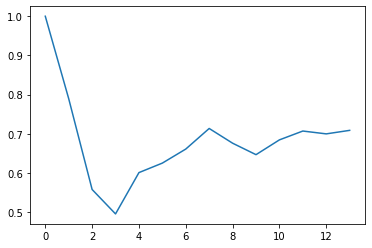

In [117]:
plt.plot(dicescores)

<ipython-input-134-462a4348c579>:8: UserWarning: No contour levels were found within the data range.
  c1 = axs[i,j].contour(masks[index], [0], colors='magenta', linewidths=2.5)


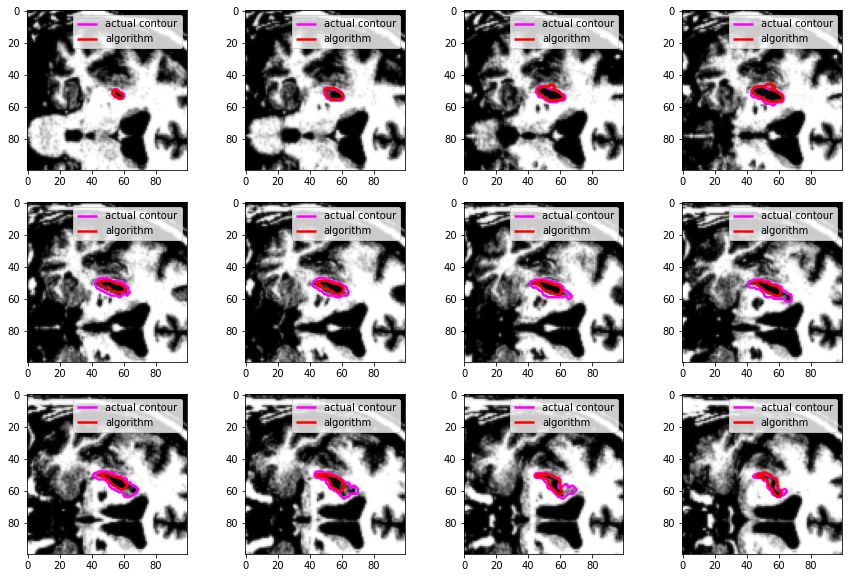

In [134]:
#lets show some subplots for the first 9 iterations here
fig, axs = plt.subplots(3, 4, figsize=(15,10))

index = 0
for i in range(3):
    for j in range(4):
        axs[i,j].imshow(scans[index], cmap='gray')
        c1 = axs[i,j].contour(masks[index], [0], colors='magenta', linewidths=2.5)
        c2 = axs[i,j].contour(contours[index].s, [0], colors='red', linewidths=2.5)

        h1,_ = c1.legend_elements()
        h2,_ = c2.legend_elements()

        axs[i,j].legend([h1[0], h2[0]], ['actual contour', 'algorithm'])
        
        index+=1


In [135]:
fig.savefig('example_run.png')

In [136]:
ls

MRI_layers_MK1.py      contour.py             scans2.ipynb
MRI_pickler.py         example_run.png        scans3.ipynb
MathUtil.java          implementation1.ipynb  simpy framework.ipynb
README.md              intensity .ipynb       test.txt
Surface.java           misc.ipynb             util.py
__pycache__/           scans.ipynb


In [104]:
dicescores

[1.0,
 0.7894736842105263,
 0.5576036866359447,
 0.49523809523809526,
 0.5380952380952381,
 0.5532786885245902,
 0.5352622061482821,
 0.4720496894409938,
 0.3210912906610703,
 0.2922636103151863,
 0.23993685872138912,
 0.21779359430604983,
 0.20172528201725282,
 0.19204042956411876]